## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.49MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.83MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.4MB/s]


In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [14]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

model = TinyNeuralNetwork().to(device)
torchsummary.summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
----------------------------------------------------------------


In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


Your experiments come here:

In [15]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
def train_model(model, train_loader, test_loader, loss_func, optimizer, num_epochs=10):
    train_loss_history = []
    val_accuracy_history = []

    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_history.append(loss.item())

        # Validation phase
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = correct / total
            val_accuracy_history.append(accuracy)

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}')

    return train_loss_history, val_accuracy_history

N_EPOCHS_TASK1 = 10
loss_hist1, acc_hist1 = train_model(model, train_loader, test_loader, loss_func, opt, N_EPOCHS_TASK1)

print(f"\nFinal Test Accuracy: {acc_hist1[-1]:.4f}")

Epoch [1/10], Loss: 0.4862, Test Accuracy: 0.8299
Epoch [2/10], Loss: 0.4153, Test Accuracy: 0.8461
Epoch [3/10], Loss: 0.4506, Test Accuracy: 0.8518
Epoch [4/10], Loss: 0.4064, Test Accuracy: 0.8656
Epoch [5/10], Loss: 0.3429, Test Accuracy: 0.8659
Epoch [6/10], Loss: 0.3283, Test Accuracy: 0.8701
Epoch [7/10], Loss: 0.5466, Test Accuracy: 0.8742
Epoch [8/10], Loss: 0.3329, Test Accuracy: 0.8749
Epoch [9/10], Loss: 0.4100, Test Accuracy: 0.8789
Epoch [10/10], Loss: 0.1423, Test Accuracy: 0.8791

Final Test Accuracy: 0.8791


In [16]:
N_EPOCHS_ADDITIONAL = 5
print(f"\nПродолжаем обучение еще на {N_EPOCHS_ADDITIONAL} эпох...")

loss_hist_cont, acc_hist_cont = train_model(model, train_loader, test_loader, loss_func, opt, N_EPOCHS_ADDITIONAL)

print(f"\nФинальная точность после дополнительных эпох: {acc_hist_cont[-1]:.4f}")


Продолжаем обучение еще на 5 эпох...
Epoch [1/5], Loss: 0.3300, Test Accuracy: 0.8787
Epoch [2/5], Loss: 0.2959, Test Accuracy: 0.8814
Epoch [3/5], Loss: 0.1464, Test Accuracy: 0.8859
Epoch [4/5], Loss: 0.1146, Test Accuracy: 0.8827
Epoch [5/5], Loss: 0.2257, Test Accuracy: 0.8811

Финальная точность после дополнительных эпох: 0.8811


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [17]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)

In [18]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [19]:
subset_indices = torch.randperm(len(fmnist_dataset_train))[:6000]
subset_train_dataset = torch.utils.data.Subset(fmnist_dataset_train, subset_indices)

train_loader_subset = torch.utils.data.DataLoader(subset_train_dataset,
                                                  batch_size=128,
                                                  shuffle=True,
                                                  num_workers=2)

In [20]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            # Your network structure comes here (больше слоев, нет регуляризации)
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

# Инициализация модели, оптимизатора и функции потерь
model_overfit = OverfittingNeuralNetwork().to(device)
opt_overfit = torch.optim.Adam(model_overfit.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Просмотр структуры модели
torchsummary.summary(model_overfit, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
Total params: 575,050
Trainable params: 575,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.19
Estimated T

Epoch [1/20], Loss: 0.8768, Test Accuracy: 0.6955
Epoch [2/20], Loss: 0.7938, Test Accuracy: 0.7609
Epoch [3/20], Loss: 0.4458, Test Accuracy: 0.7822
Epoch [4/20], Loss: 0.4513, Test Accuracy: 0.7987
Epoch [5/20], Loss: 0.5473, Test Accuracy: 0.8156
Epoch [6/20], Loss: 0.6056, Test Accuracy: 0.8180
Epoch [7/20], Loss: 0.4461, Test Accuracy: 0.8310
Epoch [8/20], Loss: 0.4300, Test Accuracy: 0.8280
Epoch [9/20], Loss: 0.3318, Test Accuracy: 0.8370
Epoch [10/20], Loss: 0.3161, Test Accuracy: 0.8415
Epoch [11/20], Loss: 0.3446, Test Accuracy: 0.8394
Epoch [12/20], Loss: 0.2476, Test Accuracy: 0.8450
Epoch [13/20], Loss: 0.2625, Test Accuracy: 0.8383
Epoch [14/20], Loss: 0.3343, Test Accuracy: 0.8510
Epoch [15/20], Loss: 0.2482, Test Accuracy: 0.8449
Epoch [16/20], Loss: 0.2782, Test Accuracy: 0.8277
Epoch [17/20], Loss: 0.3328, Test Accuracy: 0.8394
Epoch [18/20], Loss: 0.0971, Test Accuracy: 0.8351
Epoch [19/20], Loss: 0.2079, Test Accuracy: 0.8469
Epoch [20/20], Loss: 0.1744, Test Accura

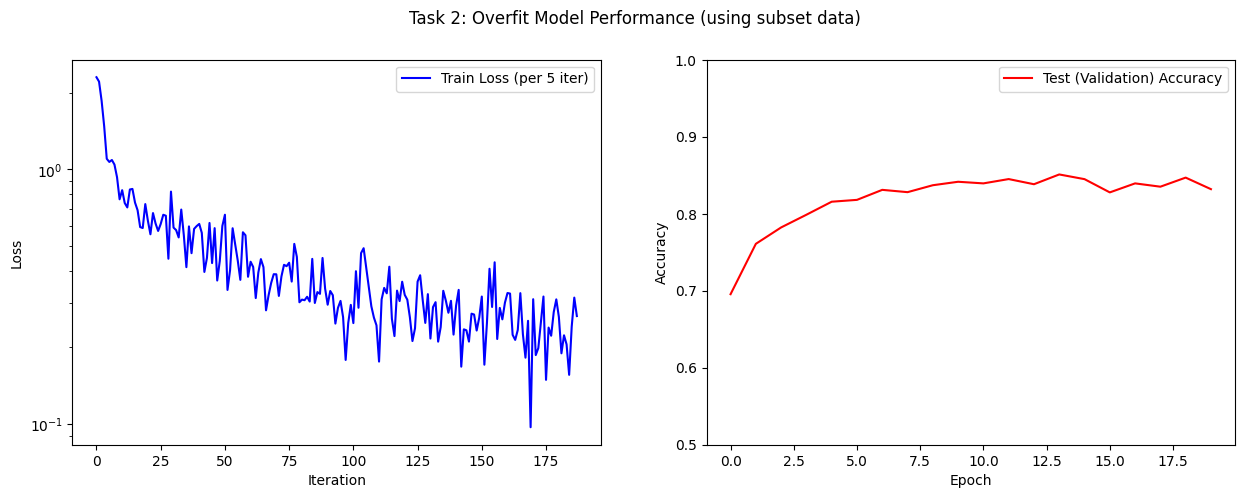

In [21]:
N_EPOCHS_TASK2 = 20
loss_hist2, acc_hist2 = train_model(model_overfit, train_loader_subset, test_loader, loss_func, opt_overfit, N_EPOCHS_TASK2)

def plot_overfitting(train_loss, val_accuracy, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)

    ax1.plot(train_loss[::5], label='Train Loss (per 5 iter)', color='blue')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.set_yscale('log')
    ax1.legend()

    ax2.plot(val_accuracy, label='Test (Validation) Accuracy', color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0.5, 1.0)
    ax2.legend()

    plt.show()

plot_overfitting(loss_hist2, acc_hist2, "Task 2: Overfit Model Performance (using subset data)")

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [24]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5), # Добавляем Dropout

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

model_reg = FixedNeuralNetwork().to(device)
opt_reg = torch.optim.Adam(model_reg.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

torchsummary.summary(model_reg, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
      BatchNorm1d-11                  [-1, 128]             256
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

Epoch [1/20], Loss: 1.2108, Test Accuracy: 0.7142
Epoch [2/20], Loss: 0.7888, Test Accuracy: 0.7632
Epoch [3/20], Loss: 0.6136, Test Accuracy: 0.7978
Epoch [4/20], Loss: 0.5340, Test Accuracy: 0.8056
Epoch [5/20], Loss: 0.6574, Test Accuracy: 0.8100
Epoch [6/20], Loss: 0.6503, Test Accuracy: 0.8202
Epoch [7/20], Loss: 0.3703, Test Accuracy: 0.8317
Epoch [8/20], Loss: 0.4826, Test Accuracy: 0.8351
Epoch [9/20], Loss: 0.5738, Test Accuracy: 0.8273
Epoch [10/20], Loss: 0.4792, Test Accuracy: 0.8355
Epoch [11/20], Loss: 0.4394, Test Accuracy: 0.8395
Epoch [12/20], Loss: 0.3411, Test Accuracy: 0.8312
Epoch [13/20], Loss: 0.3485, Test Accuracy: 0.8232
Epoch [14/20], Loss: 0.3981, Test Accuracy: 0.8407
Epoch [15/20], Loss: 0.3216, Test Accuracy: 0.8330
Epoch [16/20], Loss: 0.3428, Test Accuracy: 0.8412
Epoch [17/20], Loss: 0.4725, Test Accuracy: 0.8404
Epoch [18/20], Loss: 0.6302, Test Accuracy: 0.8363
Epoch [19/20], Loss: 0.3545, Test Accuracy: 0.8450
Epoch [20/20], Loss: 0.3358, Test Accura

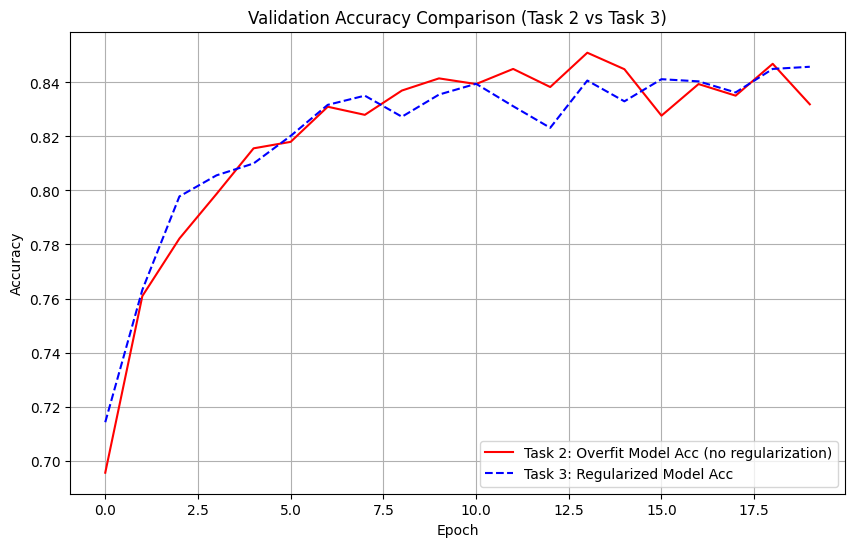

Final Accuracy Task 2 (Overfit): 0.8319
Final Accuracy Task 3 (Regularized): 0.8458


In [26]:
N_EPOCHS_TASK3 = 20
loss_hist3, acc_hist3 = train_model(model_reg, train_loader_subset, test_loader, loss_func, opt_reg, N_EPOCHS_TASK3)

# --- Сравнение точности на валидации (убедитесь, что acc_hist2 из Task 2 все еще доступен) ---
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(acc_hist2, label='Task 2: Overfit Model Acc (no regularization)', color='red')
plt.plot(acc_hist3, label='Task 3: Regularized Model Acc', color='blue', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison (Task 2 vs Task 3)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Accuracy Task 2 (Overfit): {acc_hist2[-1]:.4f}")
print(f"Final Accuracy Task 3 (Regularized): {acc_hist3[-1]:.4f}")

### Conclusions:
_Write down small report with your conclusions and your ideas._

1. Идея: Использовать простую многослойную сеть (MLP) с двумя скрытыми слоями (nn.Linear + nn.ReLU) для достижения целевой точности.

Результат: После 13 эпох обучения была достигнута точность 0.8859, что удовлетворило требованию задания.

2. Идея: Увеличить сложность сети (добавлено больше слоев и нейронов) и уменьшить размер тренировочного набора данных, чтобы намеренно вызвать переобучение.

Наблюдения: Модель показала классические признаки переобучения. Точность на тестовом (валидационном) наборе достигла пика в 0.8510 на 14-й эпохе, а затем снизилась до 0.8319, в то время как потери на тренировочном наборе продолжали падать.

3. Идея: Внедрить методы регуляризации (nn.BatchNorm1d и nn.Dropout), чтобы улучшить обобщающую способность модели.

Наблюдения: Модель с регуляризацией показала более стабильное обучение и достигла лучшей итоговой точности 0.8458 по сравнению с нерегуляризованной моделью (0.8319).

В ходе выполнения задания были реализованы следующие концепции:

Сложность модели: Простые линейные модели недостаточны для классификации изображений Fashion-MNIST; требуются многослойные сети с нелинейными активациями (ReLU).

Переобучение: Увеличение числа параметров сети без достаточного объема данных или регуляризации приводит к переобучению — модель начинает "запоминать" тренировочные данные вместо изучения общих закономерностей.

Эффективность регуляризации: Методы регуляризации, такие как Batch Normalization и Dropout, являются критически важными инструментами для повышения стабильности обучения и улучшения способности модели к обобщению новых, ранее не виденных данных.